In [4]:
# # \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\
# # \\                                                                                       \\ 
# # \\ THIS CELL SAVES THE GOODRUNS IN A SEPARATE FOLDER AFTER FIXING THE ORBIT NUMBER RESET \\
# # \\                                     RUN ONCE                                          \\
# # \\                                                                                       \\
# # \\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\\


# #Original code for this cell at https://github.com/theofil/dscout/blob/master/analysis/exampleAnalysis.ipynb
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import os
# import subprocess
# import bz2
# %matplotlib inline

# plt.rc('font', size=15)



# # data files
# path = './data/hiion/' #  The files in this path have been manually processed (removed empty files, and merged a run with two parts into one)
# files = os.listdir(path)
# files = [f for f in files if 'monitor' not in f]

# # getrunNumber from string e.g., int('/data/hiion/scout_326676_000000.monitor.txt'.split('_')[1]
# getRun = lambda x: int(x.split('_')[1])



# # list to hold dataframes
# dfs = []
# runIndex= []

# for file in files:
#     filepath = path+file
#     df = pd.read_csv(filepath)
    
  
#     # add a column with the run number
#     df['run'] = getRun(file) 
#     dfs += [df]
    
#     #make in index with the run numbers
#     runIndex += [getRun(file)]
# plt.rc('figure', max_open_warning = 100)


# #Fix the runs where the orbit number resets (the warning does not matter)

# for df in dfs:
#     if not df['orbit'].is_monotonic:
#         for i in range(1,len(df)):
#             if df['orbit'][i-1]>df['orbit'][i]:
#                 tmp = i-1
#                 break
#         df['orbit'][tmp+1:] = df['orbit'][tmp] + df['orbit'][tmp+1:]

        
# badruns = [0, 1, 4, 8, 9, 11, 28, 30, 33, 34, 35, 36, 39, 46, 47, 50,  57, 65, 68, 69, 70, 72, 77, 78]
# goodruns = [i for i in range(len(dfs)) if i not in badruns]

# dfg = [] #data frame with only goodruns

# for i in range(len(dfs)):
#     if i in goodruns : dfg.append(dfs[i])
        
# for df in dfg:
#     name = str(df['run'][0])+".txt"
#     df.to_csv("./data/goodRuns/"+name, index = False) # The folder goodRuns needs to be manually made

C:\Users\George\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time 
import datetime
%matplotlib inline

plt.rc('font', size=15)
plt.rc('figure', max_open_warning = 100)

# data files
path = './data/goodRuns/' #  The files in this path have been manually processed (removed empty files, and merged a run with two parts into one)
files = os.listdir(path)
files = [f for f in files]

# list to hold dataframes
dfg = []

timeUnit = 1 # in seconds

for file in files:
    filepath = path+file
    df = pd.read_csv(filepath)
    dfg.append(df)

TimeLog = pd.read_csv("https://raw.githubusercontent.com/theofil/dscout/master/analysis/runsDateTimeLog.txt",
                      delimiter = ', ', engine = 'python')

luminosity = [len(dfg[i]) for i in range(len(dfg))]

duration = TimeLog['duration'].to_list()

durationSecs = []
for deltat in duration:
    h, m, s=deltat.split(":")
    durationSecs.append( datetime.timedelta(hours = int(h), minutes = int(m), seconds = int(s)).total_seconds())
    
luminosity = np.array(luminosity)
durationSecs = np.array(durationSecs)
rate = luminosity/durationSecs

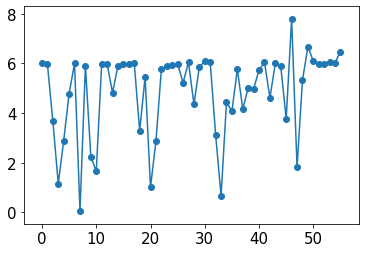

In [43]:
plt.plot([i for i in  range(len(rate))], rate)
plt.scatter([i for i in  range(len(rate))], rate)